The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

In [7]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [8]:
df.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1


# Data exploration

In [9]:
df.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,36861.000000,33706.000000,33708.000000,33264.000000,31114.000000,2203.000000,565.000000,39723.000000,41396.000000
mean,6.039527,3.094612,3.319212,2.805886,2.392364,2.736723,2.249558,3.164111,0.533820
std,3.214680,1.405515,1.541307,1.580246,1.704753,1.569073,1.541283,1.523486,0.498861
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41396 entries, 0 to 41395
Data columns (total 20 columns):
airline_name                     41396 non-null object
link                             41396 non-null object
title                            41396 non-null object
author                           41396 non-null object
author_country                   39805 non-null object
date                             41396 non-null object
content                          41396 non-null object
aircraft                         1278 non-null object
type_traveller                   2378 non-null object
cabin_flown                      38520 non-null object
route                            2341 non-null object
overall_rating                   36861 non-null float64
seat_comfort_rating              33706 non-null float64
cabin_staff_rating               33708 non-null float64
food_beverages_rating            33264 non-null float64
inflight_entertainment_rating    31114 non-null float64
ground_se

* From this descriptive table, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. 
* It is noticeable that data for overall rating, recommended and value_money rating are nearly full while rating data for ground service and wifi connectivity are mostly missing.However, we should not assume that it is becaus travellers tend to pay more attention to these rating when they score and leave out other ratings or because some airlines simply don't provide these amenities in some routes. Hence, I think it's more logical to replace those missing values by 0 than by imputed values(mean, median). 
* The data points with missing values for overall rating will be deleted as it is our main concern. 

* we will need to change some categorical features above into category type. Date into date type, but we may not need it in this model

In [11]:
df.groupby('type_traveller').size()

type_traveller
Business          362
Couple Leisure    601
FamilyLeisure     611
Solo Leisure      804
dtype: int64

* This shows that we have lots of missing data for type of travellers

In [12]:
df.groupby('cabin_flown').size()

cabin_flown
Business Class      6347
Economy            29784
First Class          879
Premium Economy     1510
dtype: int64

* Those missing points in this case are not many, so we just replace with 0 for missing values

In [13]:
len(df['airline_name'].unique()) #how many airlines operate

362

In [14]:
len(df['author_country'].unique()) #to see whether the reviews come from just some countries

159

In [15]:
len(df['aircraft'].unique()) #how many types of aircraft

364

In [16]:
len(df['route'].unique()) #how many routes

2209

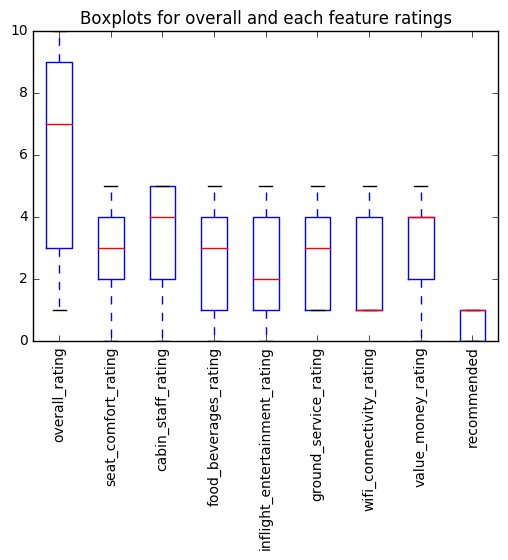

In [17]:
df.plot.box()
plt.xticks(rotation='vertical')
plt.title('Boxplots for overall and each feature ratings')
plt.show()

* the boxplot may not be useful yet because of many missing values and denoted as 0 in our data

# Data wrangling

In the data cleaning step, I do the following:
* Only choose data since 2010
* Drop data without overall rating
* Drop information that is not needed for feature selection purpose: link, title, author, author country, date, content, aircraft type, route
* Encode missing values as 0
* Get dummies for traveller type and cabin flown 

In [18]:
df.date=pd.to_datetime(df.date) #change date object into datetime format
df=df[df.date>='2010-01-01'] #choose recent dates only
df.shape

(39539, 20)

In [19]:
#drop data points without overall rating
df_clean=df[df['overall_rating'].notnull()]

In [20]:
#'link','title','author','author_country','date','content','aircraft','route'
df_clean.drop(['airline_name','link','title','author','author_country','date','content','aircraft','route'],axis=1, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
df_clean.head()

,type_traveller,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,NaN,Economy,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,NaN,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,NaN,Economy,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1
3,NaN,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1
4,NaN,Economy,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0


In [22]:
#deal with missing values
df_clean=df_clean.fillna({'ground_service_rating':0, 'wifi_connectivity_rating':0,'seat_comfort_rating':0,'cabin_staff_rating':0,'food_beverages_rating':0,'inflight_entertainment_rating':0, 'value_money_rating':0}, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [23]:
#replace missing value of categorical variables with their mode
#df_clean=df_clean.fillna(df_clean.mode().iloc[0])


In [24]:
#change types cabin flown and traveler types into category type
df_cabin_flown= pd.get_dummies(df_clean['cabin_flown'])
df_clean=pd.concat([df_clean, df_cabin_flown], axis=1)
df_clean.drop(['cabin_flown'], axis=1, inplace=True)

df_type_traveller= pd.get_dummies(df_clean['type_traveller'])
df_clean=pd.concat([df_clean, df_type_traveller], axis=1)
df_clean.drop(['type_traveller'], axis=1, inplace=True)

In [25]:
df_clean.isnull().values.any() #check if there are any missing values in dataframe

False

In [26]:
df_clean.head()

,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,Business Class,Economy,First Class,Premium Economy,Business,Couple Leisure,FamilyLeisure,Solo Leisure
0,7.0,4.0,4.0,4.0,0.0,0.0,0.0,4.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,4.0,5.0,4.0,1.0,0.0,0.0,5.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,5.0,5.0,4.0,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,4.0,4.0,3.0,1.0,0.0,0.0,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,2.0,1.0,2.0,0.0,0.0,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_clean.shape

(35799, 17)

# Modelling

In order to get the most important features that may affect overall rating, the following steps are conducted:
    * Classifiers: Ridge regression, Lasso regression, Random forest
    * Divide dataset into train/testset and use cross validation with 5 folds 
    * Metrics: R^2 and RMSE(root mean squared error)

In [28]:
y=df_clean.overall_rating
X=df_clean.drop(['overall_rating'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=1)
from sklearn.metrics import mean_squared_error

#### Ridge regression

In [56]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
ridge_model=RidgeCV(alphas=(0,0.1,0.3, 0.5,0.7,1.0, 10.0), cv=10).fit(Xlr,ylr)
model=SelectFromModel(ridge_model, prefit=True)
model_new=model.transform(Xlr)
model_new.shape


(26849, 6)

In [57]:
#RSS_ridge=sum((ridge_model.predict(Xlr)-ylr)**2)
print('alpha=', ridge_model.alpha_)
print('R^2 score: ',ridge_model.score(Xlr,ylr))
print('mean squared error on train set:', mean_squared_error(ylr,ridge_model.predict(Xlr)))

RSS_ridge=sum((ridge_model.predict(Xtestlr)-ytestlr)**2)
print('R^2 on test set: ',ridge_model.score(Xtestlr,ytestlr))
print('mean squared error on test set:', mean_squared_error(ytestlr,ridge_model.predict(Xtestlr)))

alpha= 1.0
R^2 score:  0.808491313228
mean squared error on train set: 1.9896058502
R^2 on test set:  0.816968945027
mean squared error on test set: 1.90215213476


#### Random forest

In [49]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=200, random_state=1)
forest.fit(Xlr,ylr)
importances = forest.feature_importances_
names=list(Xlr.columns.values)
features = []
indices = np.argsort(importances)[::-1]

for f in range(len(importances)):
    print("%d. feature %d (%f), %s" % (f + 1, indices[f], importances[indices[f]], names[indices[f]]))
    features.append(indices[f])
    # Print only first 10 most important variables
    if len(features) >= 10:
        break
featurenames = [names[feature] for feature in features]

1. feature 7 (0.826211), recommended
2. feature 6 (0.057429), value_money_rating
3. feature 1 (0.048717), cabin_staff_rating
4. feature 0 (0.020524), seat_comfort_rating
5. feature 3 (0.015610), inflight_entertainment_rating
6. feature 2 (0.015597), food_beverages_rating
7. feature 9 (0.003723), Economy
8. feature 8 (0.003379), Business Class
9. feature 4 (0.002342), ground_service_rating
10. feature 11 (0.001674), Premium Economy


Feature ranking:


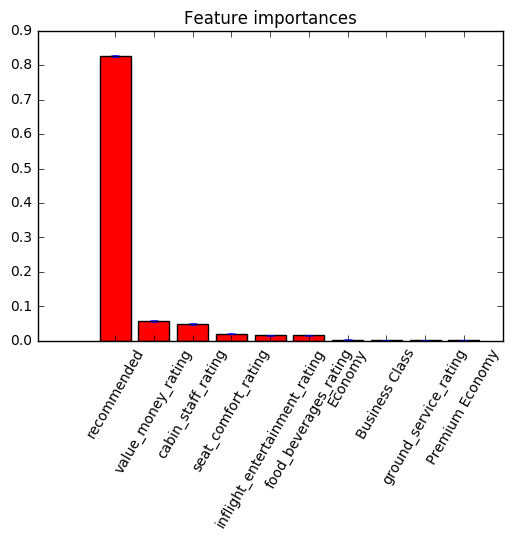

In [50]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)

# Plot the feature importances of the forest
print('Feature ranking:')
fig=plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(len(features)), featurenames,rotation=60)
plt.show()
fig.savefig('feature important.png')

* So value-money rating and wifi connectivity are most important features that may affect overall rating

In [55]:
results = model_selection.cross_val_score(forest, Xlr, ylr, cv=5)
print('R^2 on train set', results.mean())
print('mean squared error:', mean_squared_error(ylr,forest.predict(Xlr) ))
print('R^2 on test set:',forest.score(Xtestlr,ytestlr))
print('mean squared error:', mean_squared_error(ytestlr,forest.predict(Xtestlr) ))

R^2 on train set 0.847520006929
mean squared error: 1.01677125839
R^2 on test set: 0.852863501184
mean squared error: 1.52911758807
